# All ocean Analysis

The objective is to run graphs to set the basic analisis of the oceans and get the ranges and things to input into the music generator


# Base code

## Init and functions

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point

import folium
import geopandas as gpd

from ndbc_api import NdbcApi

import plotly.io as pio
import plotly.graph_objects as go
import seaborn as sns
import matplotlib.pyplot as plt

pio.renderers.default = "notebook_connected"

api = NdbcApi()

In [3]:
def load_buoy_data(filename):
    with pd.HDFStore(filename) as store:
        availability_df = store['availability']
        station_data = {}
        for key in store.keys():
            if key.startswith('/station_'):
                station = key.split('_', 1)[1]
                station_data[station] = store[key]
    
    return station_data, availability_df

def filter_by_ocean(availability_df, cleaned_station_data, buoys_df, ocean_name):
    
    # Filter buoys_df to get stations from the specified ocean
    ocean_stations = buoys_df[buoys_df['Ocean'] == ocean_name]['Station'].tolist()

    # Filter availability_df
    filtered_availability = availability_df.loc[availability_df.index.intersection(ocean_stations)]
    
    # Remove columns filled with zero
    filtered_availability = filtered_availability.loc[:, (filtered_availability != 0).any(axis=0)]

    # Filter cleaned_station_data
    filtered_station_data = {station: data for station, data in cleaned_station_data.items() if station in ocean_stations}

    return filtered_availability, filtered_station_data


def create_buoy_ocean_map(buoy_df, geojson_path, output_path='buoy_ocean_map.html'):
    """
    Create a Folium map with ocean polygons and buoy locations.
    
    Parameters:
    buoy_df (pandas.DataFrame): DataFrame containing buoy information with columns 'Lat', 'Lon', 'Station', and 'Ocean'.
    geojson_path (str): Path to the GeoJSON file containing ocean polygons.
    output_path (str): Path to save the output HTML map file. Default is 'buoy_ocean_map.html'.
    
    Returns:
    folium.Map: The created Folium map object.
    """
    
    # Create a Folium map centered around the average of the buoy coordinates
    m = folium.Map(location=[buoy_df['Lat'].mean(), buoy_df['Lon'].mean()], zoom_start=2)

    # Load the GeoJSON file
    oceans_gdf = gpd.read_file(geojson_path)

    # Add ocean polygons from GeoJSON
    folium.GeoJson(
        oceans_gdf.__geo_interface__,
        style_function=lambda feature: {
            'fillColor': 'lightblue',
            'color': 'black',
            'weight': 1,
            'fillOpacity': 0.5,
        }
    ).add_to(m)

    # Define a color mapping for each ocean
    ocean_colors = {
        'Atlantic Ocean': 'blue',
        'Pacific Ocean America': 'green',
        'Indian Ocean': 'red',
        'Southern Ocean': 'purple',
        'Pacific Ocean Asia': 'green'
    }

    # Add buoy locations to the map
    for idx, row in buoy_df.iterrows():
        # Get the color for the current ocean, default to orange if not found
        icon_color = ocean_colors.get(row['Ocean'], 'orange')
        
        folium.Marker(
            location=(row['Lat'], row['Lon']),
            popup=f'Buoy {row["Station"]}\n ({row["Lat"]}, {row["Lon"]})\n{row["Ocean"]}',
            icon=folium.Icon(color=icon_color)
        ).add_to(m)

    # Save the map to an HTML file
    m.save(output_path)

    return m


def plot_availability_heatmap(availability):
    # Remove columns (variables) with no data
    availability = availability.loc[:, (availability != 0).any(axis=0)]
    # Create the heatmap
    fig = go.Figure(data=go.Heatmap(
        z=availability.values,
        x=availability.columns,
        y=availability.index,
        colorscale='YlGnBu',
        colorbar=dict(title='Data Available')
    ))
    
    # Update layout
    fig.update_layout(
        title='Data Availability by Station and Variable',
        xaxis_title='Variable',
        yaxis_title='Station',
        height=600,
        width=1000
    )
    
    # Show the plot
    fig.show()



def ocean_variable_plot_interactive(ocean_station_data, ocean_availability):
    # Get all variables from the availability dataframe
    variables = ocean_availability.columns.tolist()
    
    # Color palette for different stations
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', 
              '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

    for variable in variables:
        fig = go.Figure()

        for j, (station, data) in enumerate(ocean_station_data.items()):
            if variable in data.columns and ocean_availability.loc[station, variable] == 1:
                trace = go.Scatter(
                    x=data.index,
                    y=data[variable],
                    mode='lines',
                    name=f'{station}',
                    line=dict(color=colors[j % len(colors)]),
                )
                fig.add_trace(trace)
        
        # Update layout
        fig.update_layout(
            height=600,
            title_text=f"{variable} Data from Ocean Buoys",
            xaxis_title="Date",
            yaxis_title=variable,
            legend_title_text="Stations",
        )

        # Show the plot
        fig.show()

def ocean_variable_plot_non_interactive(ocean_station_data, ocean_availability, max_legend_items=10, separate_legend=False):
    # Get all variables from the availability dataframe
    variables = ocean_availability.columns.tolist()
    
    # Color palette for different stations
    colors = sns.color_palette("husl", n_colors=len(ocean_station_data))

    for variable in variables:
        fig, ax = plt.subplots(figsize=(12, 6))

        legend_handles = []
        legend_labels = []

        for j, (station, data) in enumerate(ocean_station_data.items()):
            if variable in data.columns and ocean_availability.loc[station, variable] == 1:
                line = ax.plot(
                    data.index,
                    data[variable],
                    label=station,
                    color=colors[j % len(colors)],
                )
                legend_handles.append(line[0])
                legend_labels.append(station)
        
        # Update layout
        ax.set_title(f"{variable} Data from Ocean Buoys")
        ax.set_xlabel("Date")
        ax.set_ylabel(variable)

        # Rotate x-axis labels for better readability
        plt.xticks(rotation=45)

        # Handle legend
        if len(legend_handles) > max_legend_items:
            if separate_legend:
                # Create a separate figure for the legend
                legend_fig, legend_ax = plt.subplots(figsize=(10, len(legend_handles)*0.4))
                legend_ax.axis('off')
                legend = legend_ax.legend(legend_handles, legend_labels, loc='center', title="Stations")
                legend_fig.tight_layout()
            else:
                # Add a scrollable legend to the main plot
                ax.legend(legend_handles[:max_legend_items], 
                          legend_labels[:max_legend_items], 
                          title=f"Stations (showing {max_legend_items} of {len(legend_handles)})",
                          bbox_to_anchor=(1.05, 1), 
                          loc='upper left')
        else:
            ax.legend(title="Stations", bbox_to_anchor=(1.05, 1), loc='upper left')

        # Adjust layout to prevent cutting off labels
        plt.tight_layout()

        # Show the plot
        plt.show()

        if separate_legend and len(legend_handles) > max_legend_items:
            plt.show()  # Show the separate legend figure
    
def ocean_variable_plot(ocean_station_data, ocean_availability, interactive=False):
    if interactive:
        ocean_variable_plot_interactive(ocean_station_data, ocean_availability)
    else:
        ocean_variable_plot_non_interactive(ocean_station_data, ocean_availability)

In [4]:
# Read the general information of all Buoys
buoy_df = pd.read_csv('buoys_with_ocean.csv')

# Load the data from buoys
station_data, availability_df = load_buoy_data('buoy_data_20240601_to_20240916.h5')


## Display buoys in the map

In [5]:
# Show buoys in the map

m = create_buoy_ocean_map(buoy_df, '5oceansByNick.geojson')
m  # Display the map


## Indian Ocean

In [6]:

# Filter to only this Ocean
indian_ocean_availability, indian_ocean_station_data = filter_by_ocean(availability_df, station_data, buoy_df, "Indian Ocean")


In [7]:
plot_availability_heatmap(indian_ocean_availability)

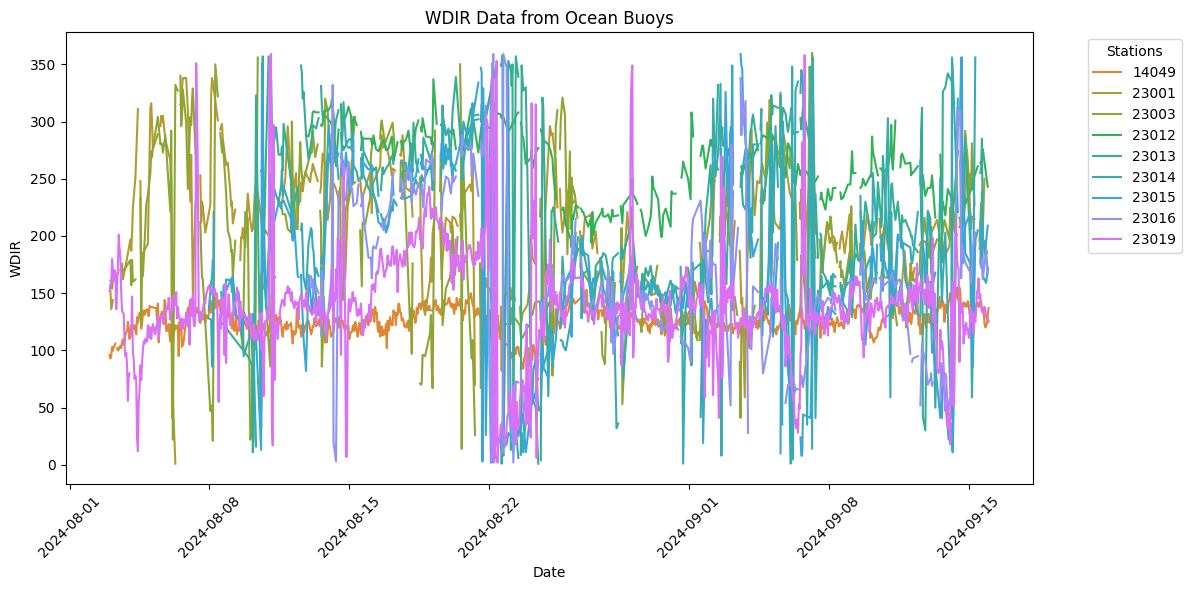

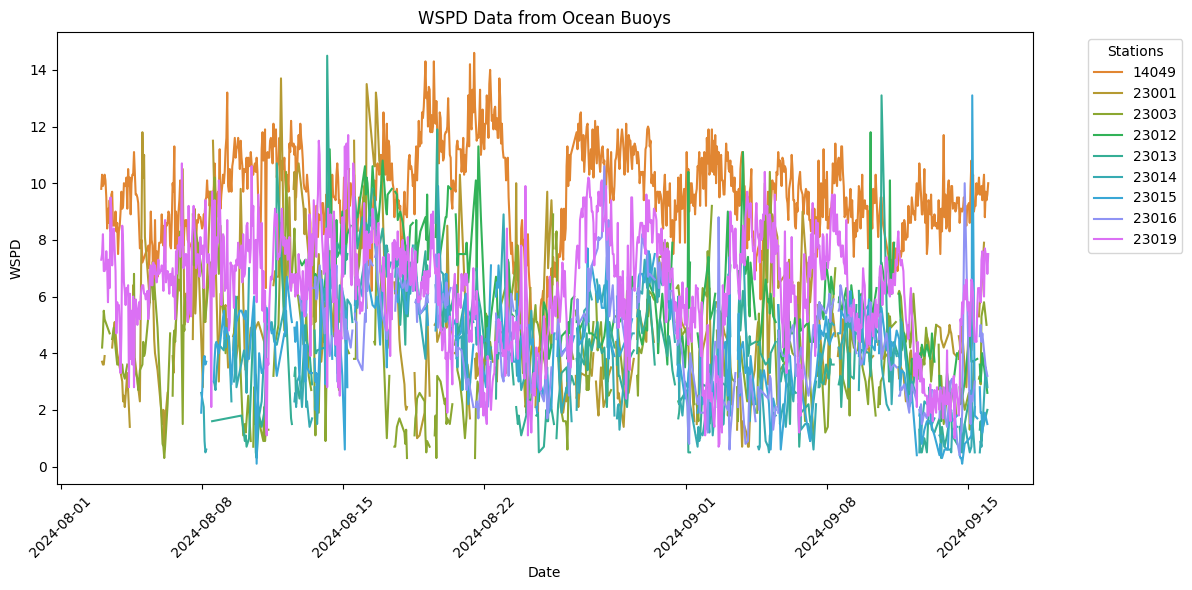

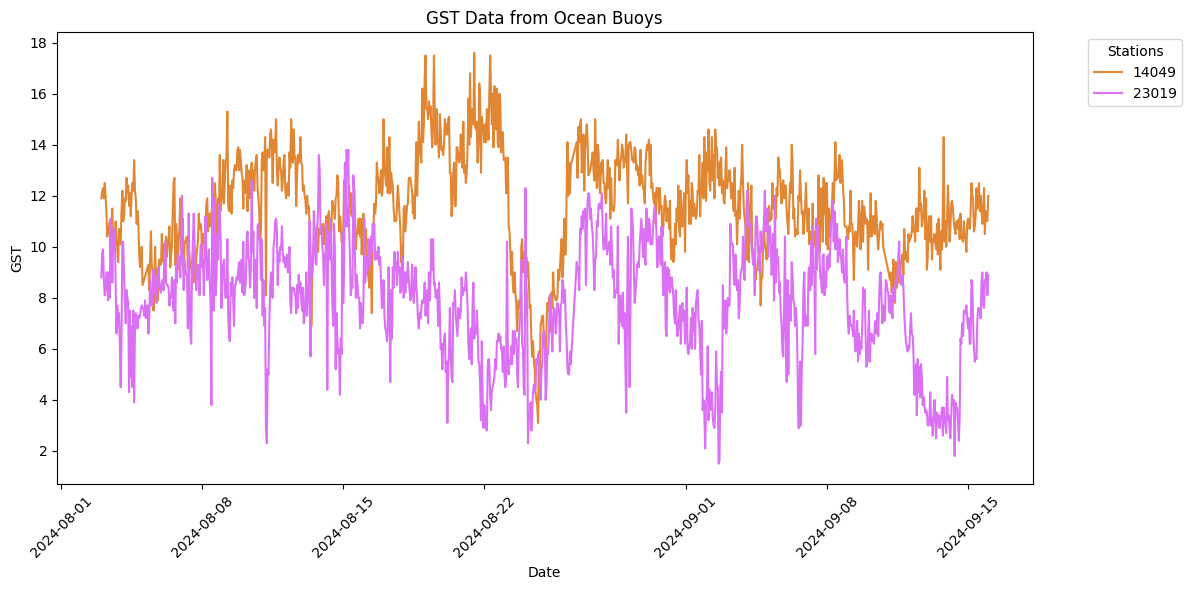

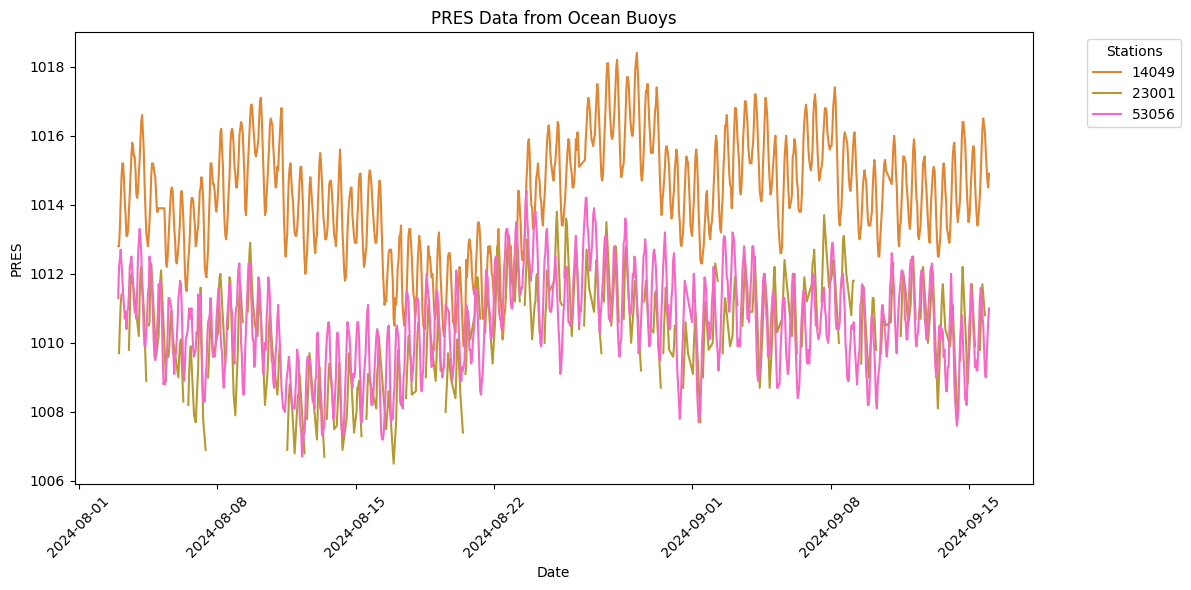

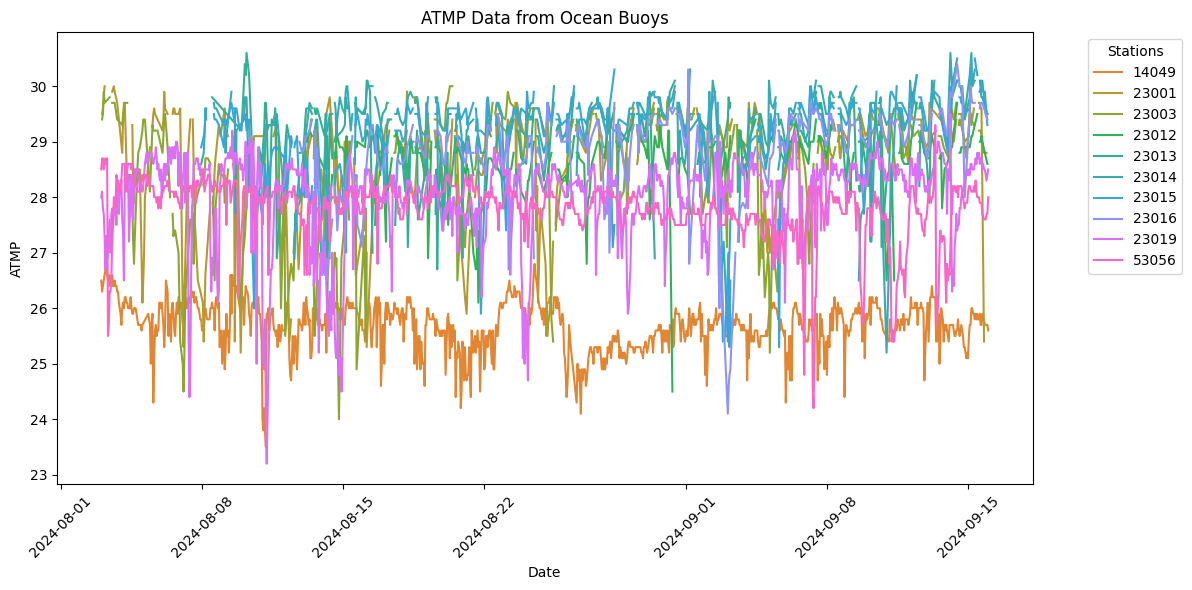

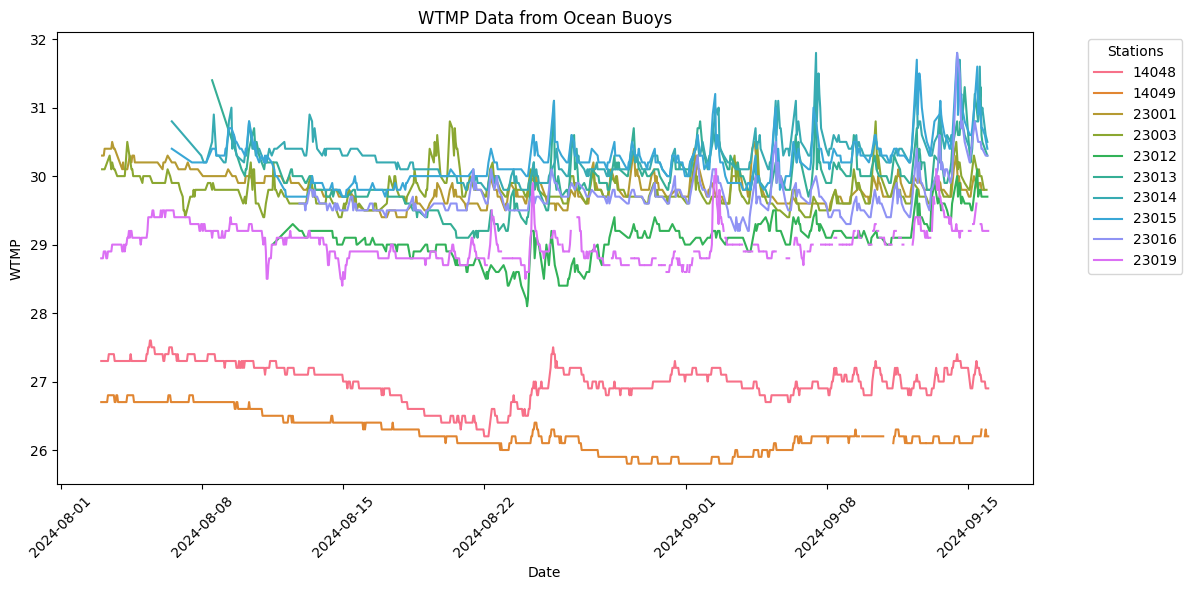

In [8]:


#  Plot the variables:
ocean_variable_plot(indian_ocean_station_data, indian_ocean_availability)


# Atlantic Ocean

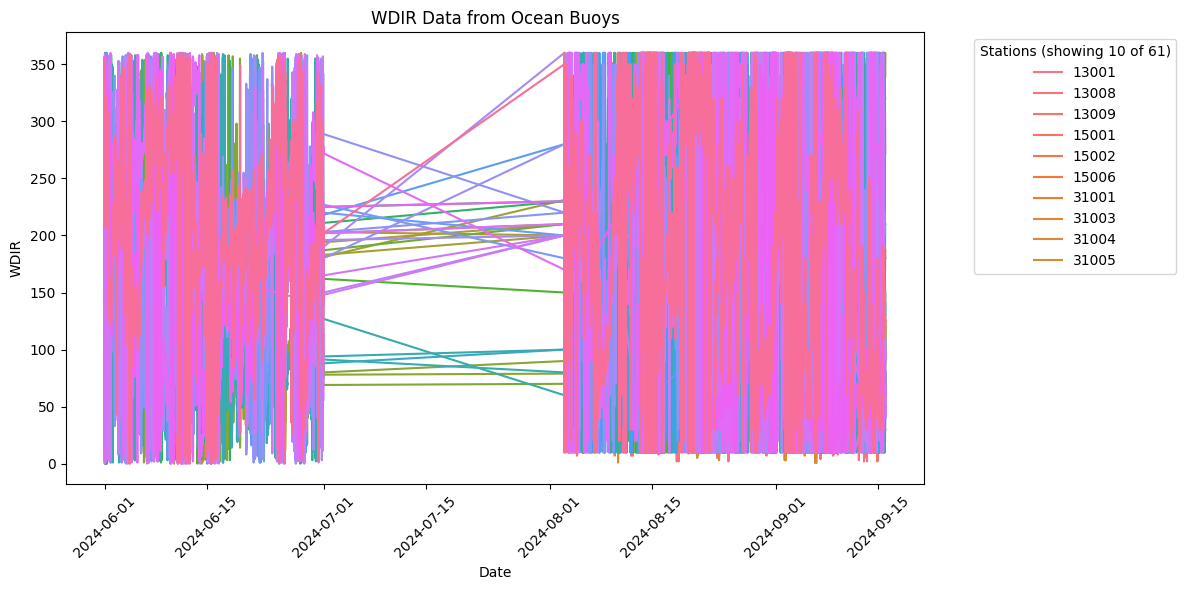

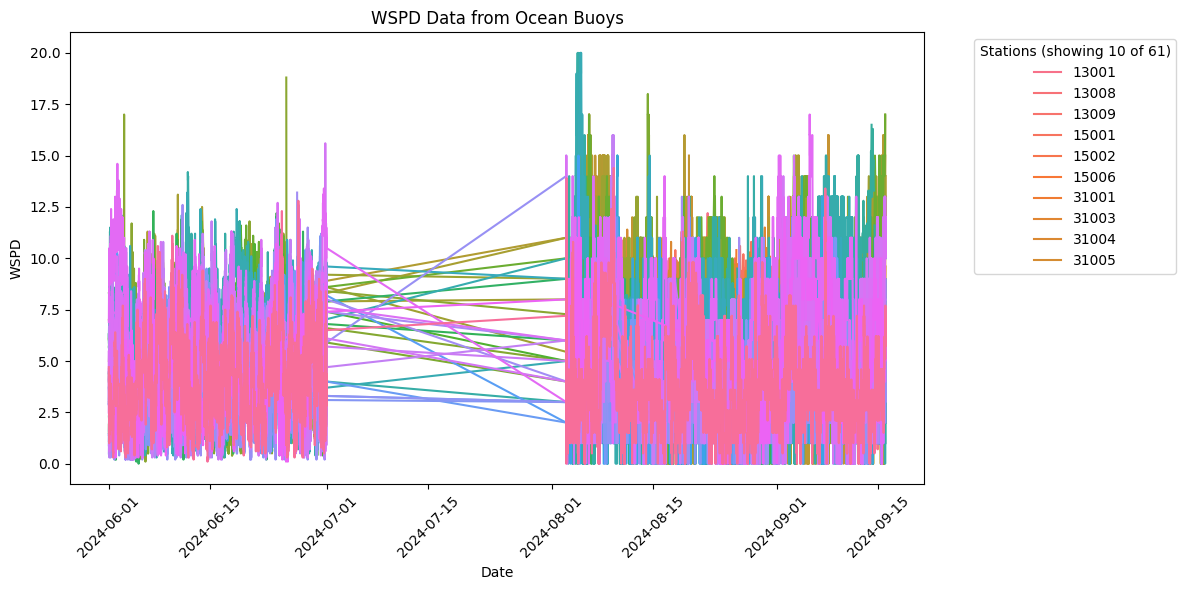

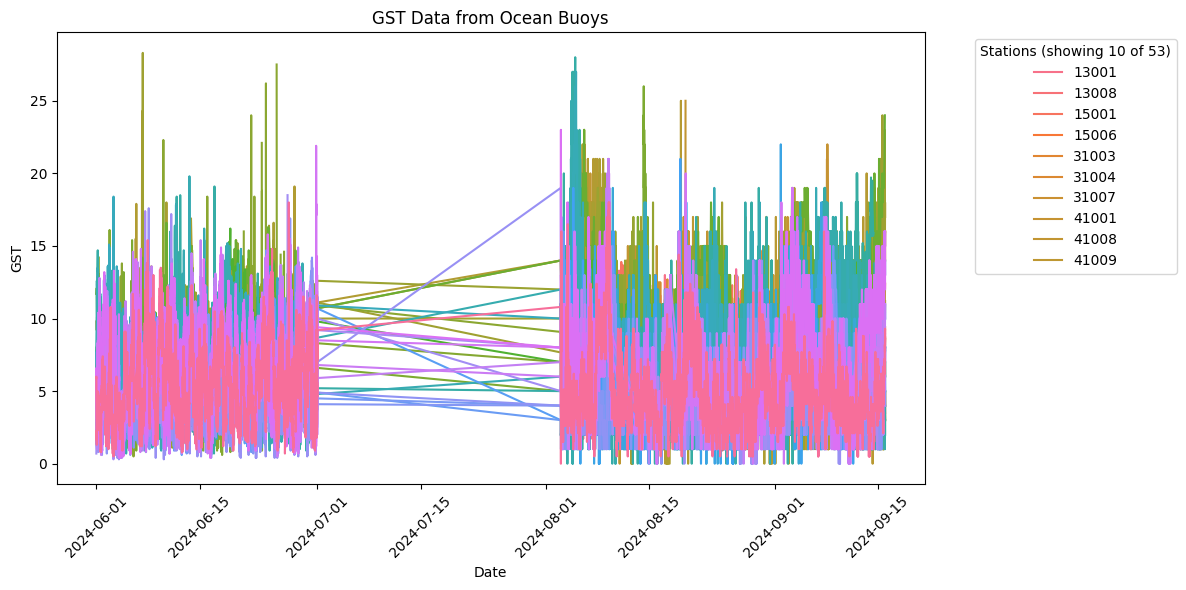

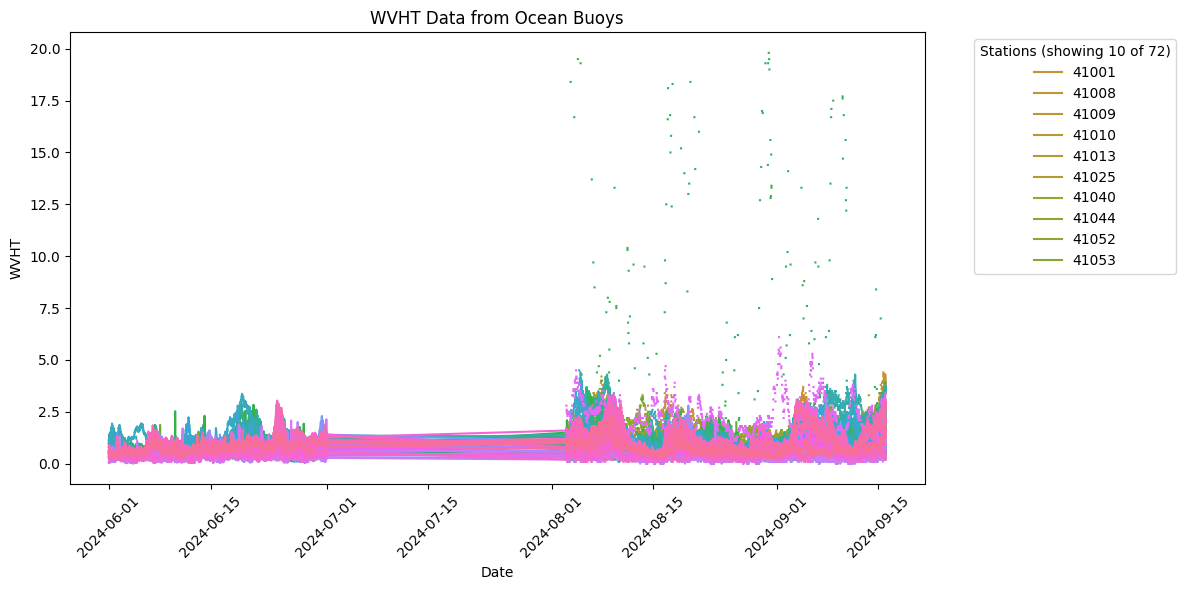

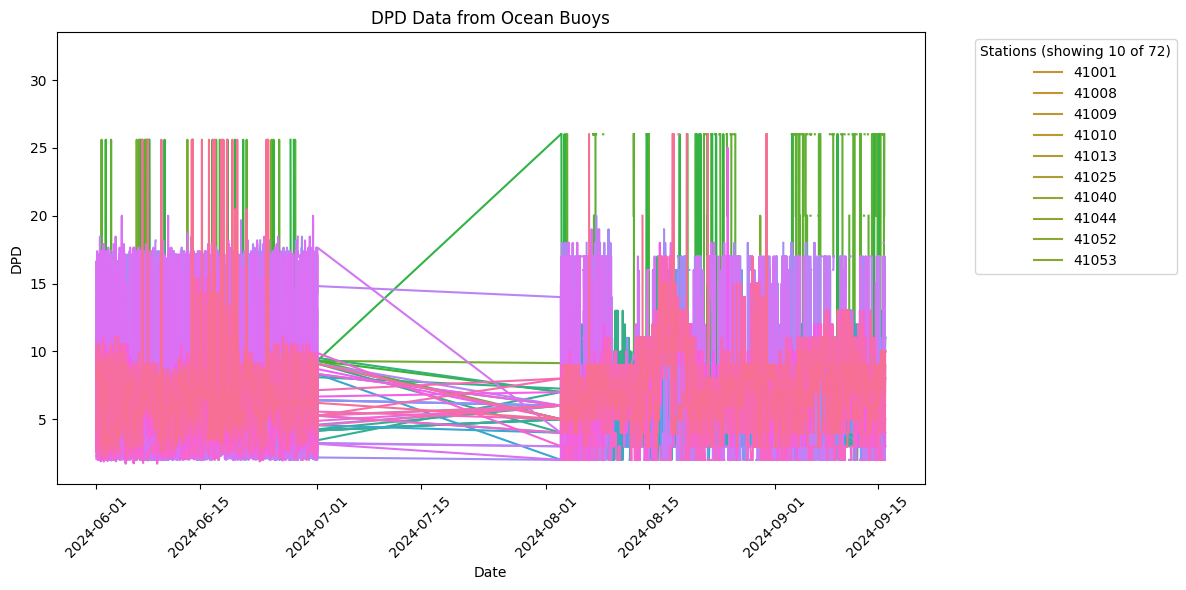

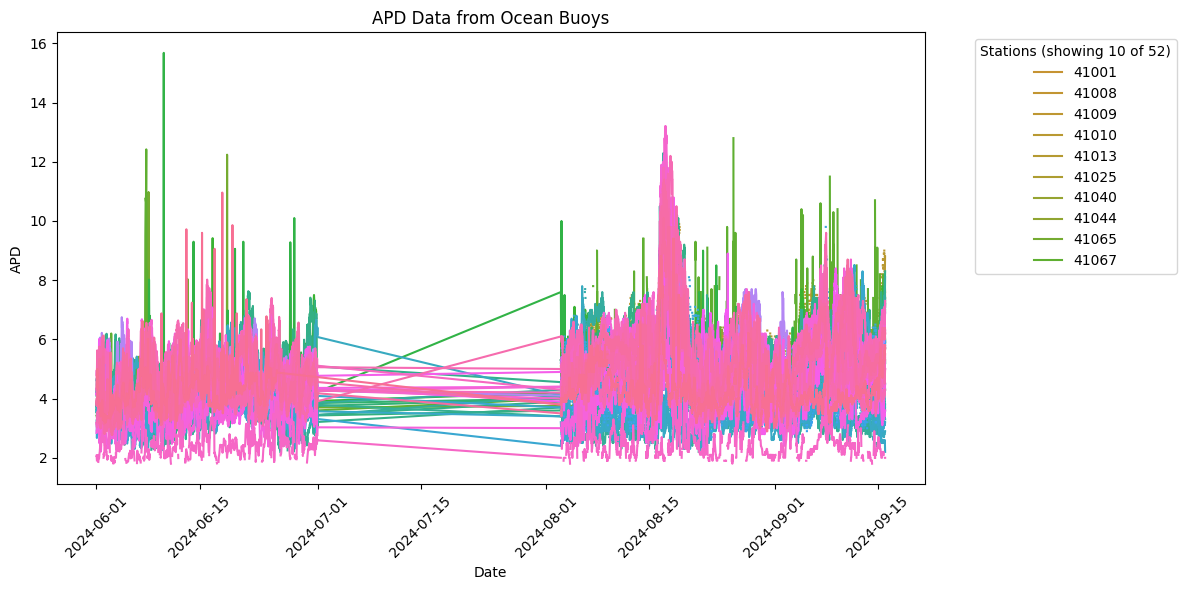

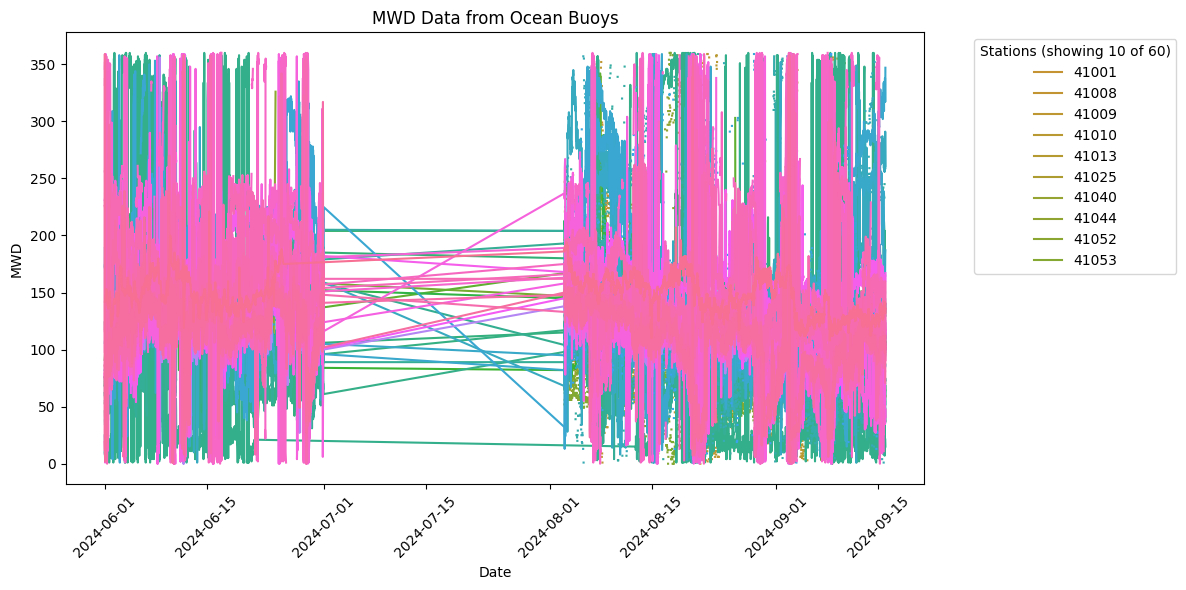

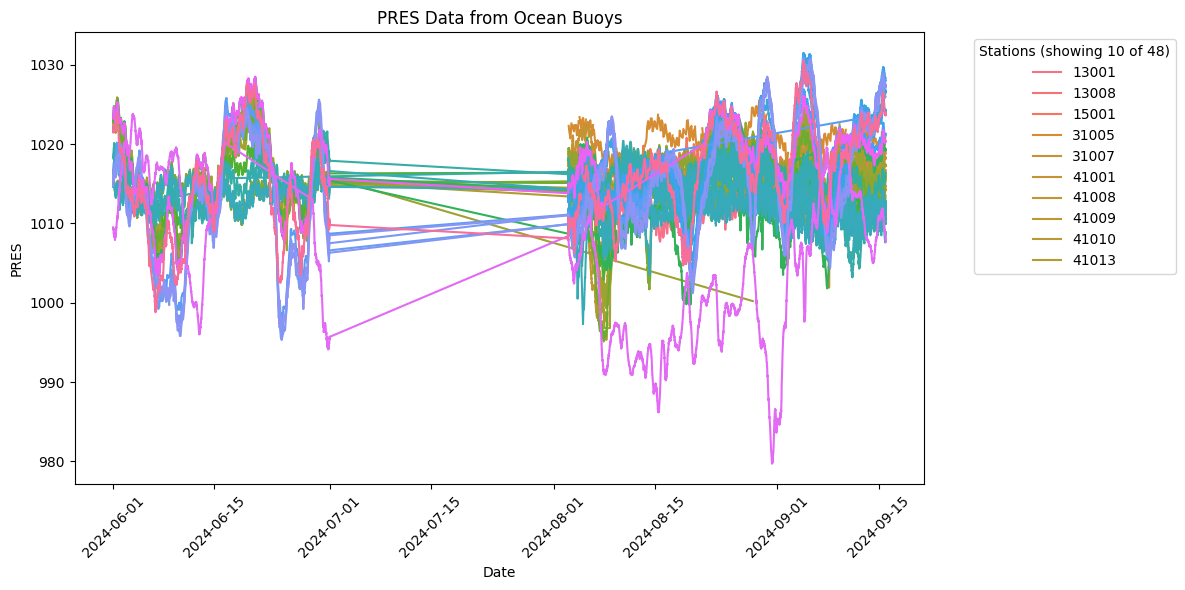

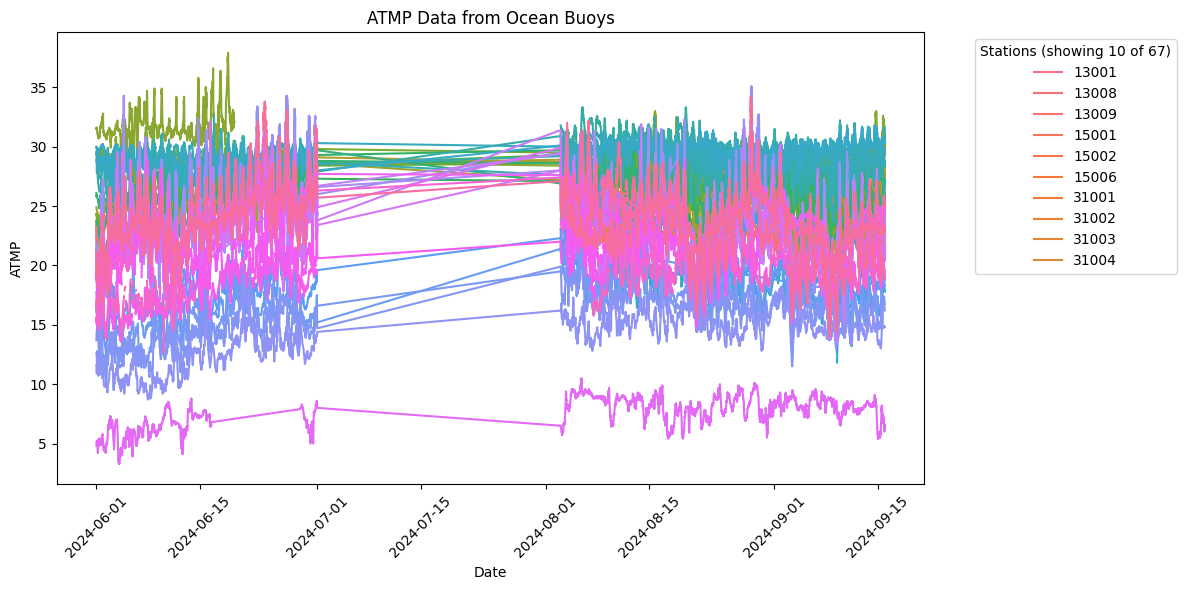

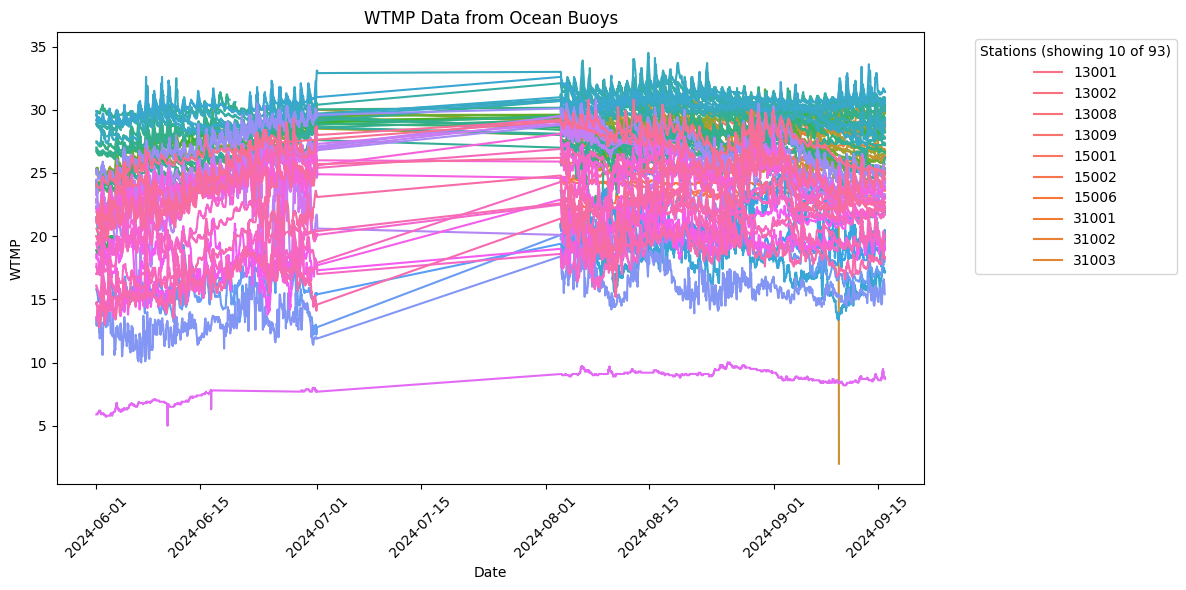

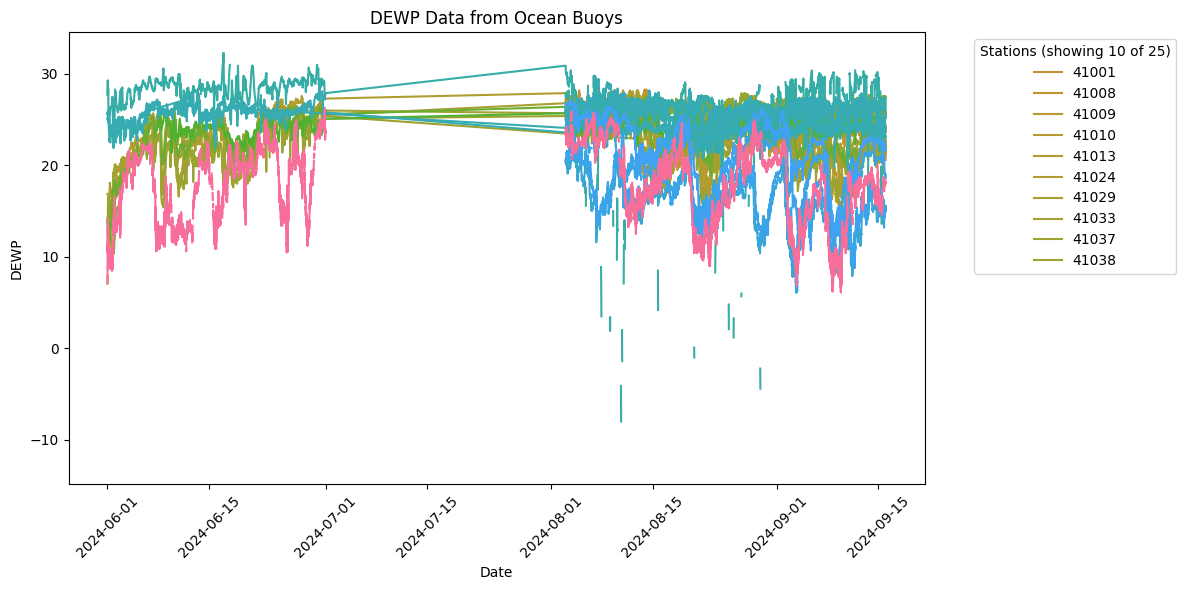

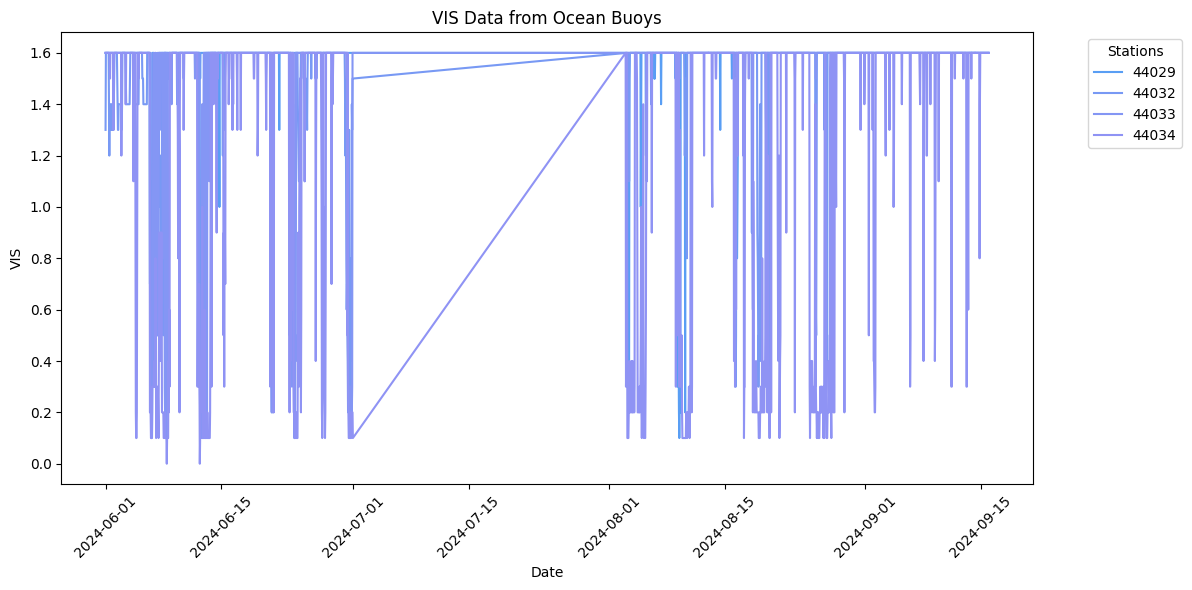

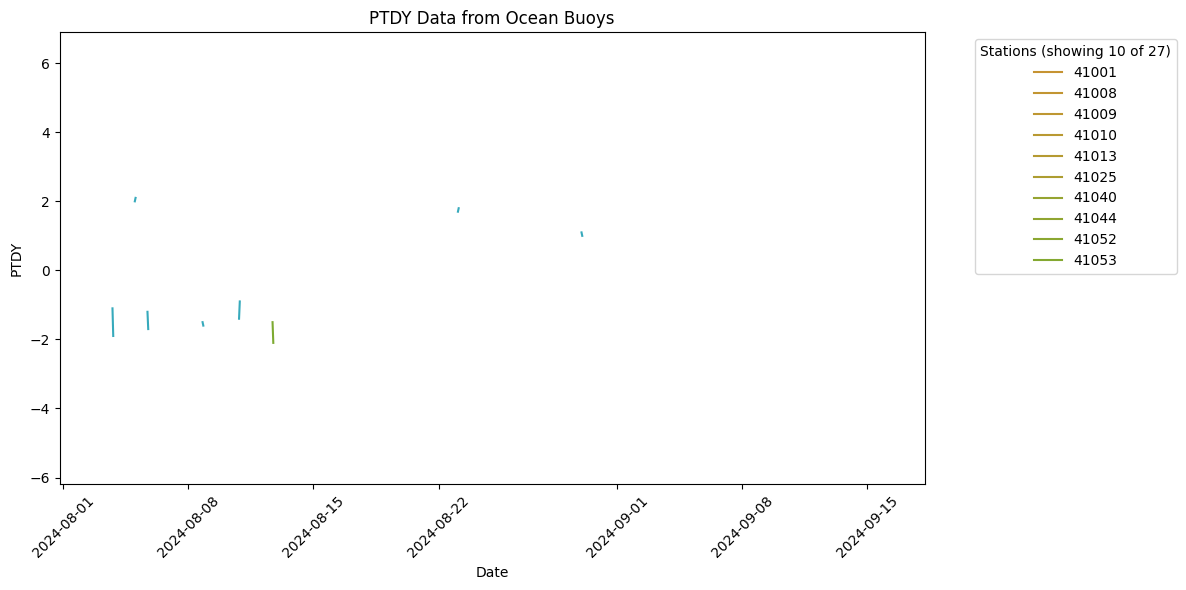

In [9]:

# Filter to only this Ocean
atlantic_ocean_availability, atlantic_ocean_station_data = filter_by_ocean(availability_df, station_data, buoy_df, "Atlantic Ocean")
plot_availability_heatmap(atlantic_ocean_availability)
#  Plot the variables:
ocean_variable_plot(atlantic_ocean_station_data, atlantic_ocean_availability)



## Pacific Ocean Asia

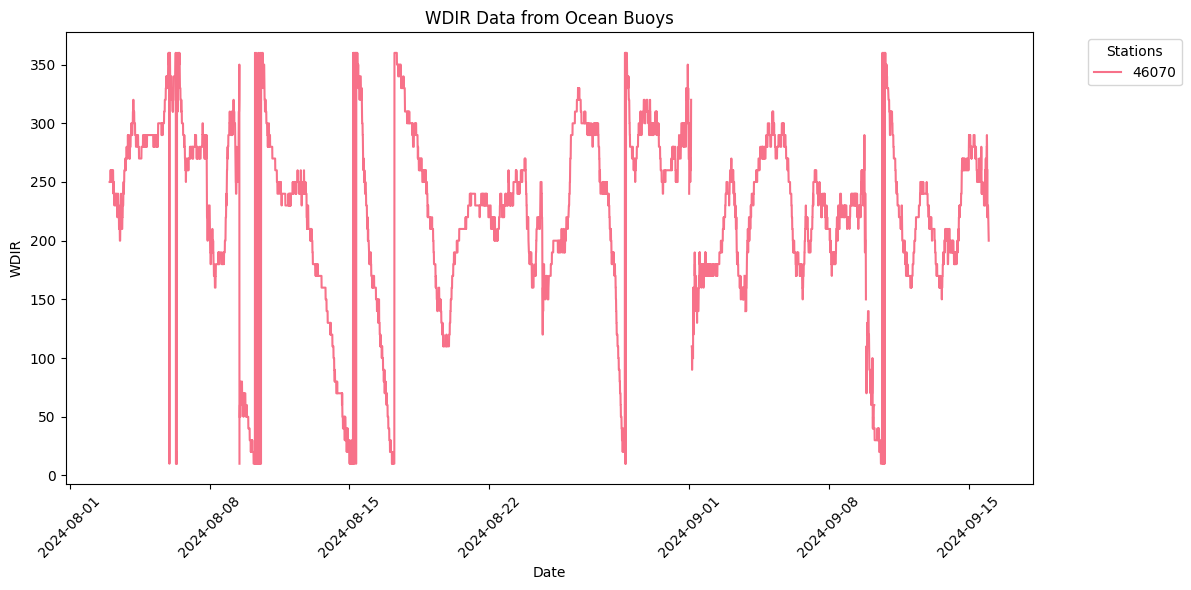

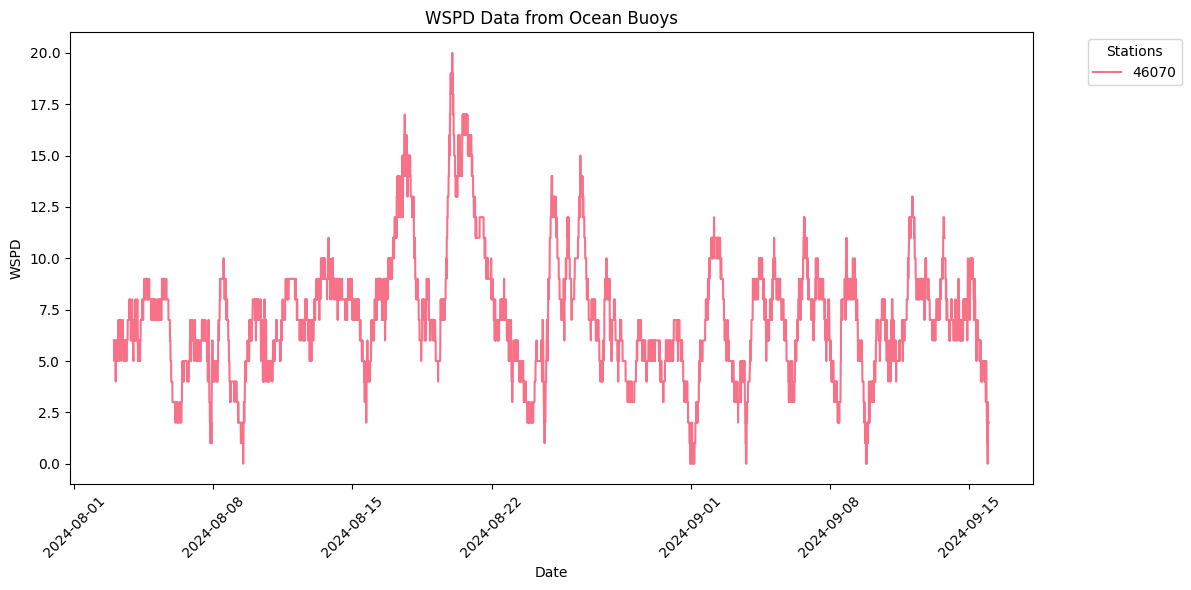

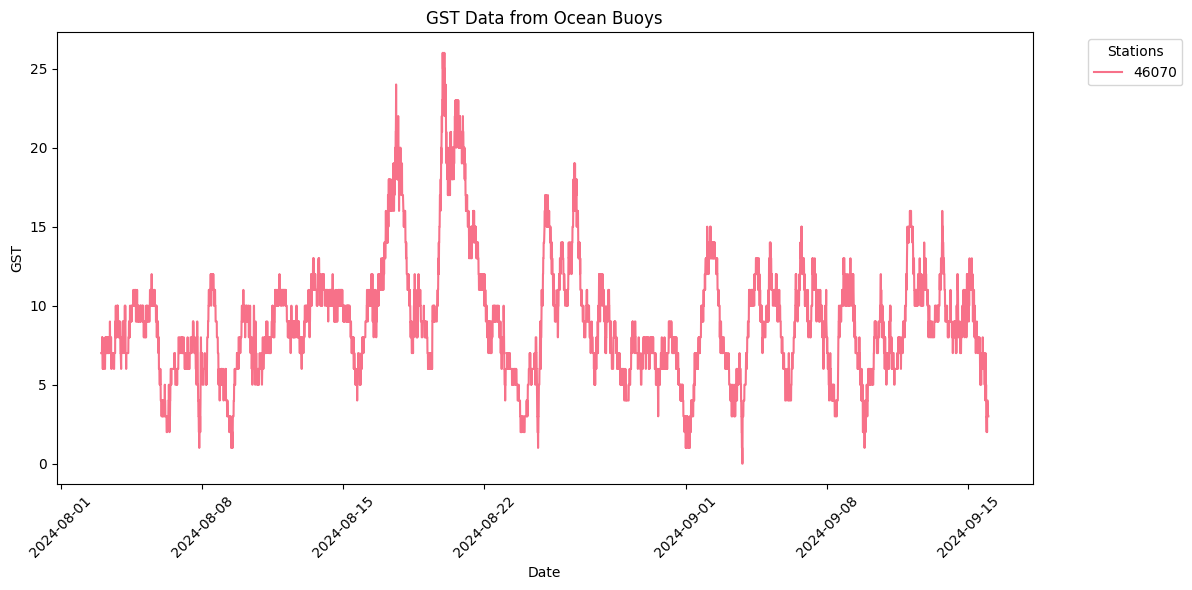

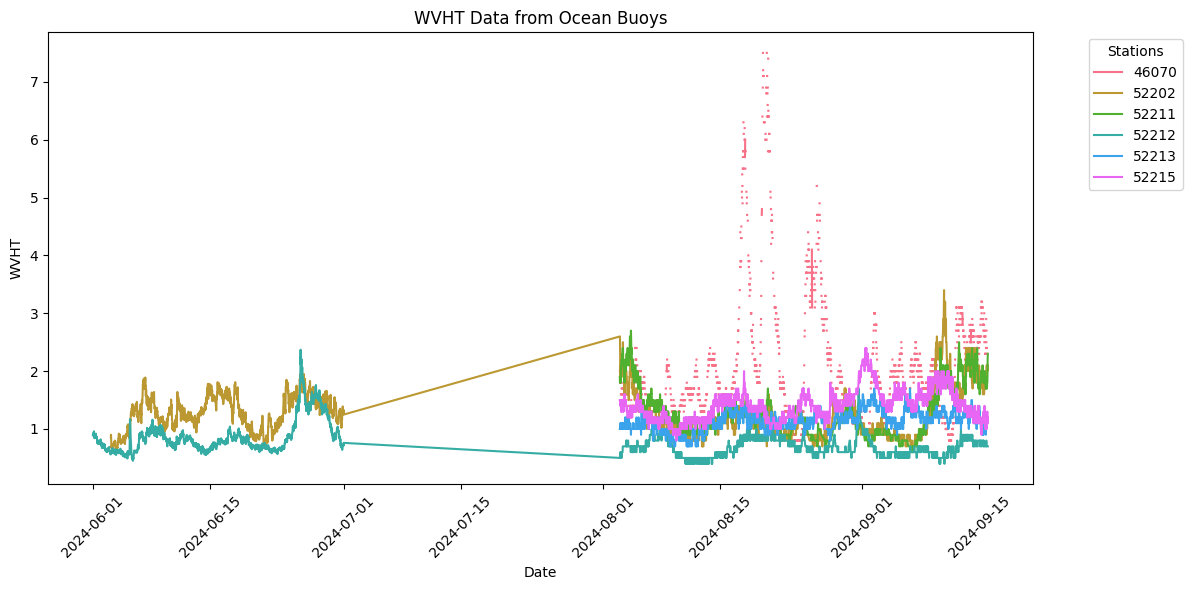

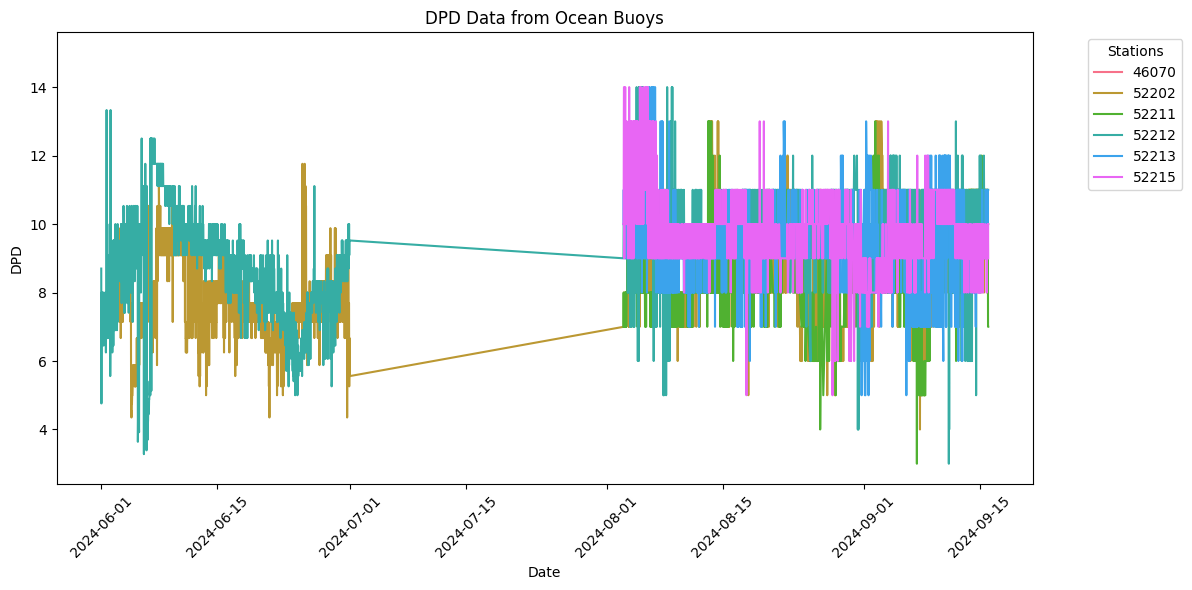

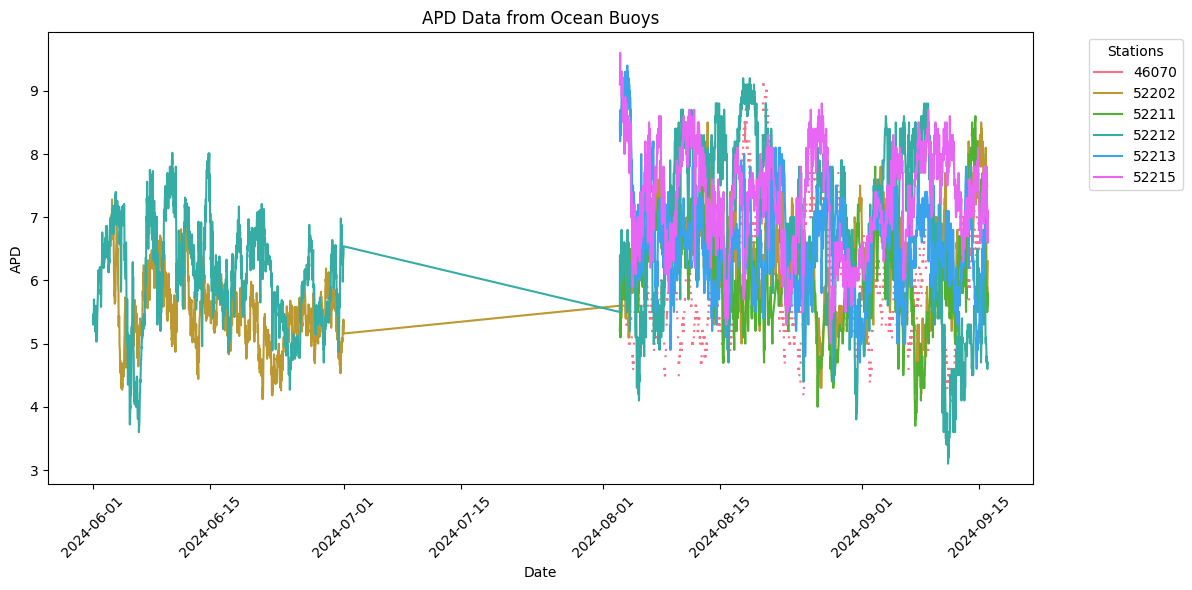

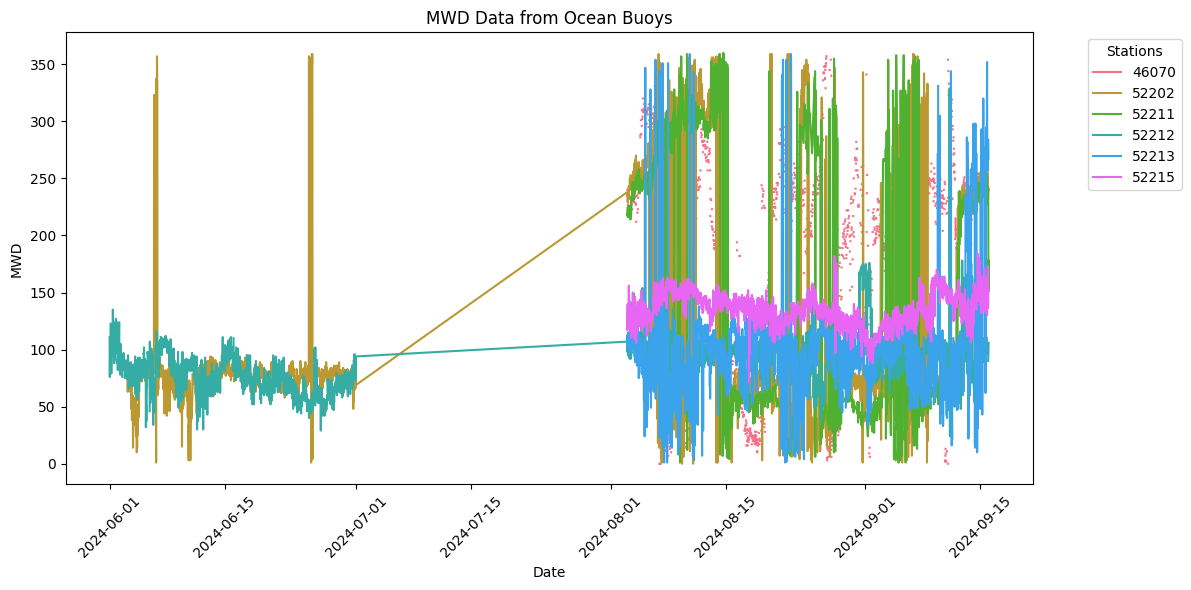

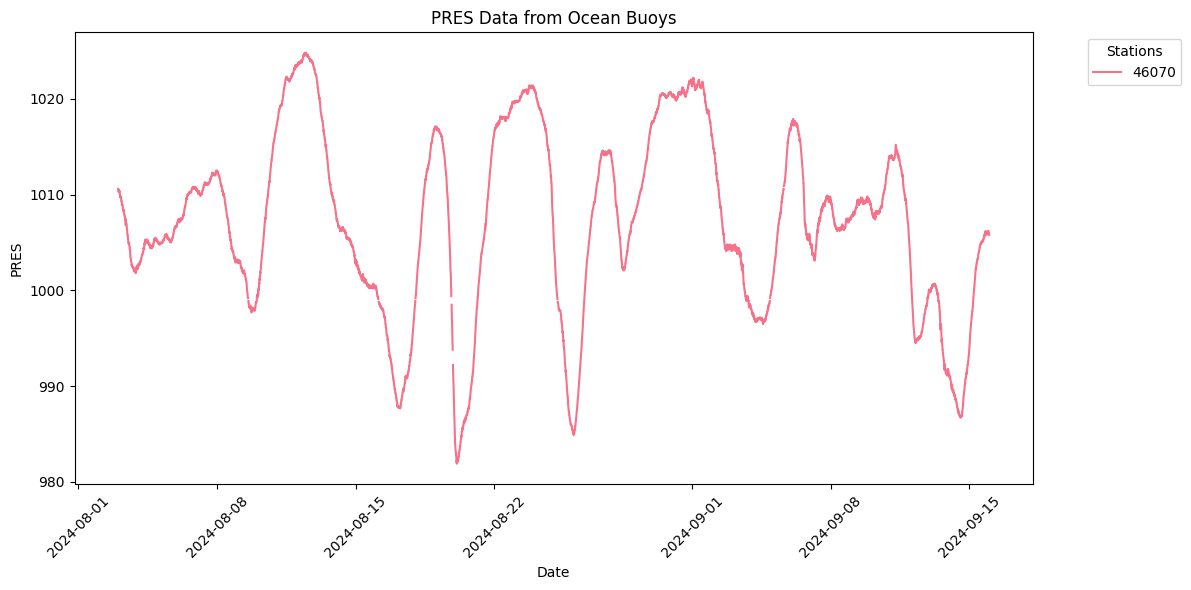

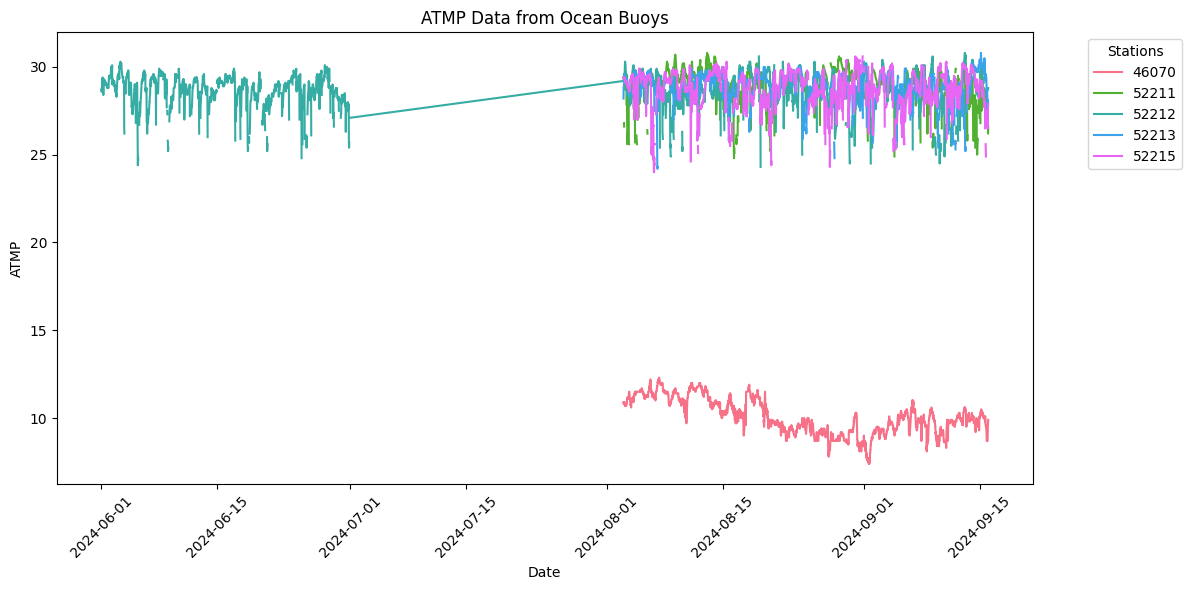

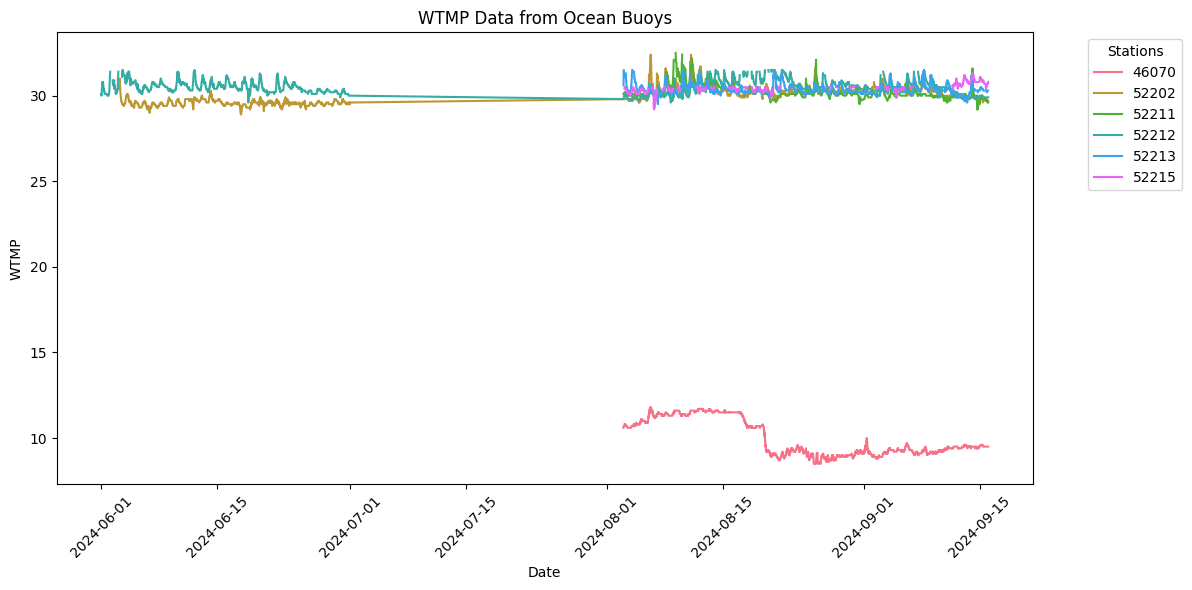

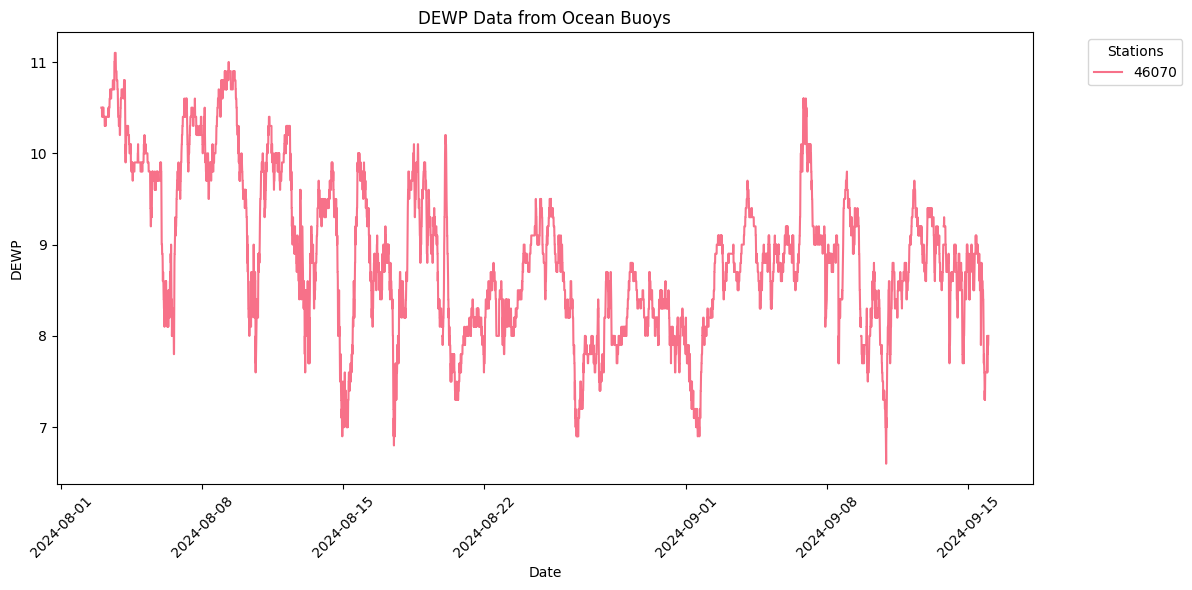

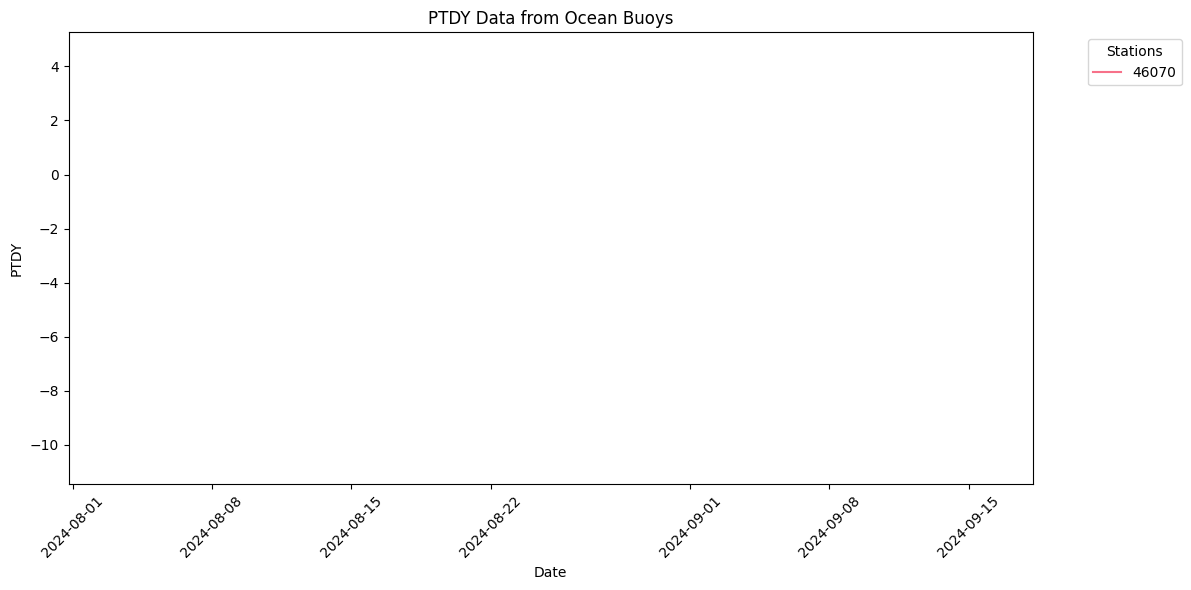

In [10]:
# Filter to only this Ocean
pacific_asian_ocean_availability, pacific_asian_ocean_station_data = filter_by_ocean(availability_df, station_data, buoy_df, "Pacific Ocean Asia")
plot_availability_heatmap(pacific_asian_ocean_availability)
#  Plot the variables:
ocean_variable_plot(pacific_asian_ocean_station_data, pacific_asian_ocean_availability)

# Pacific Ocean America

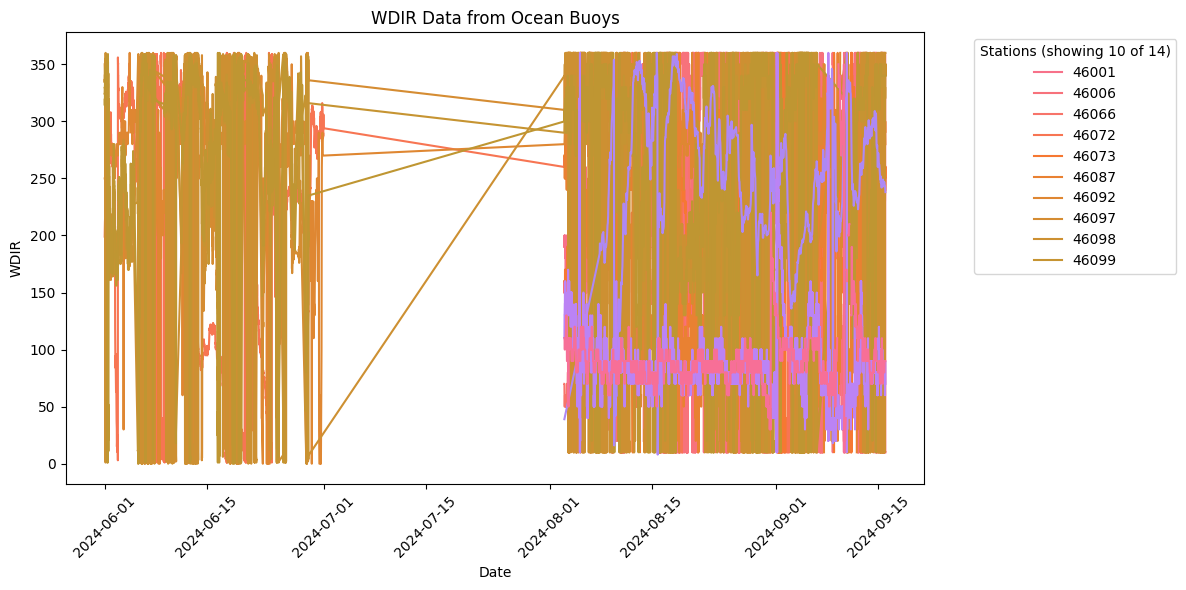

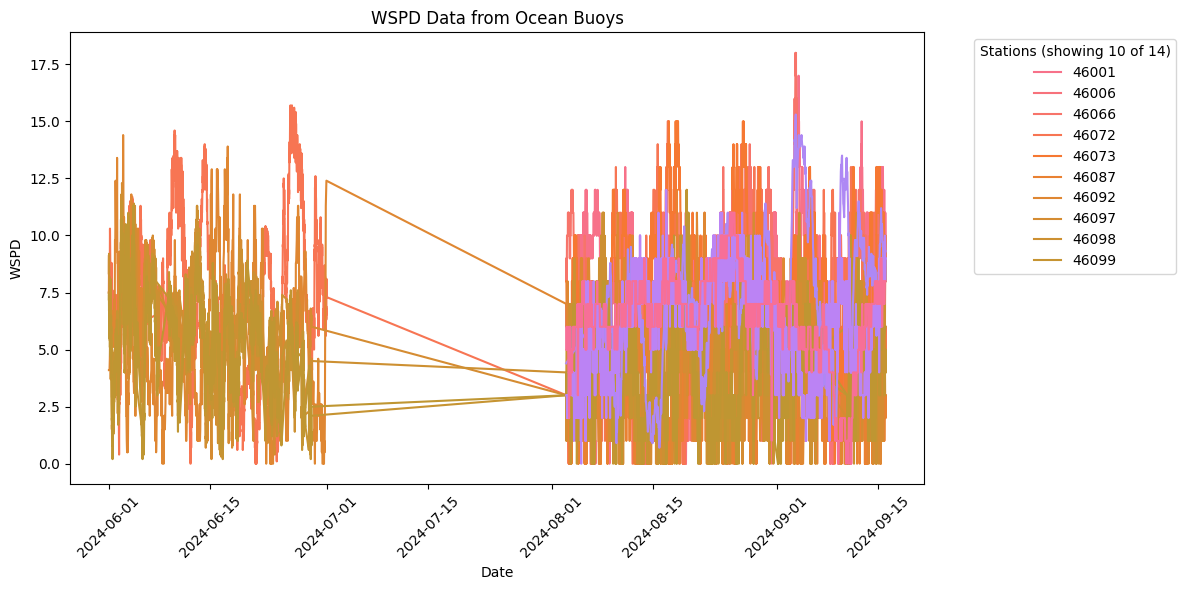

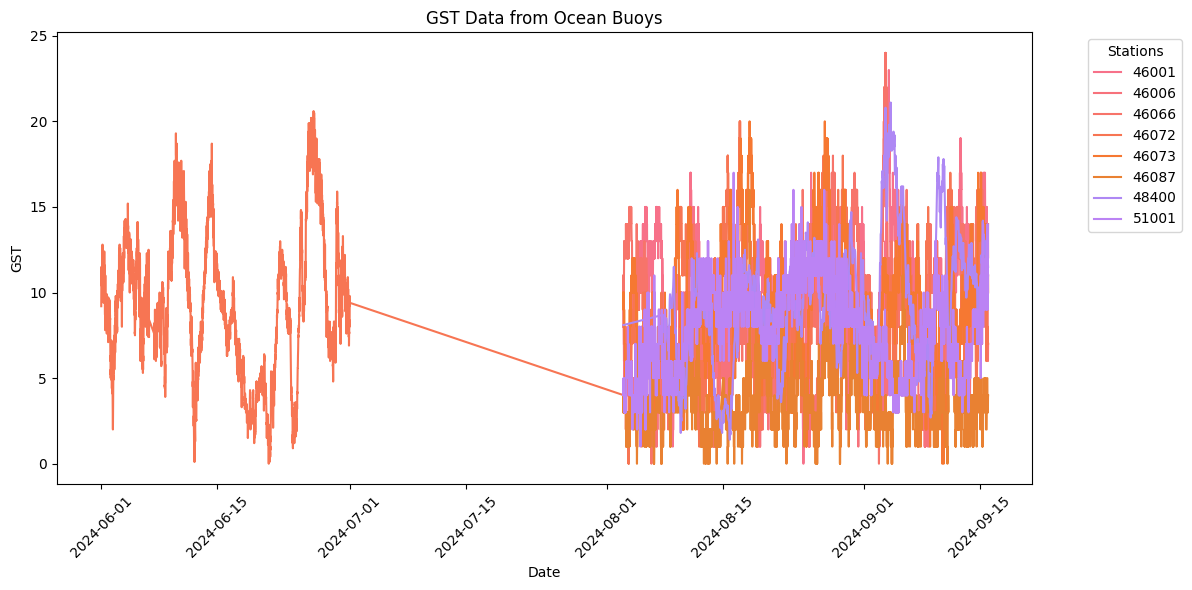

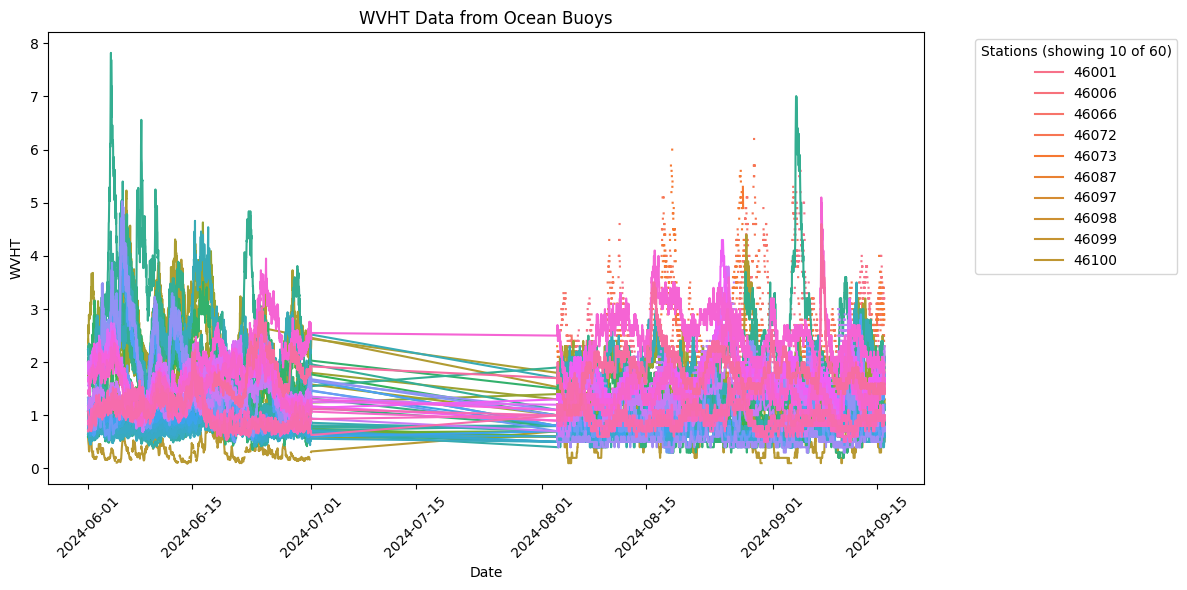

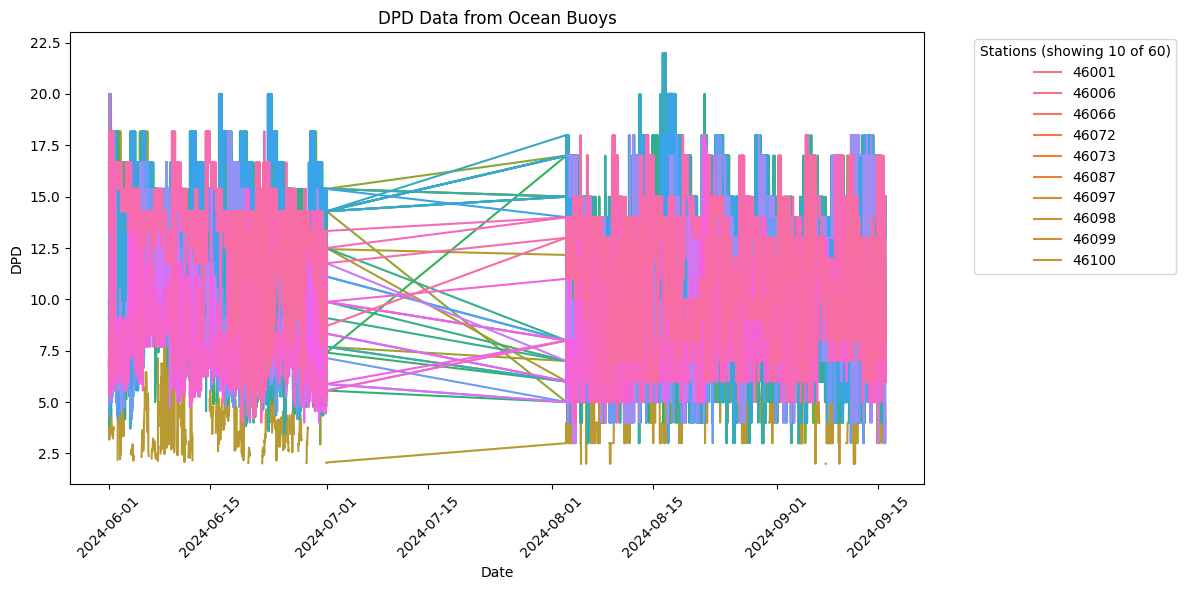

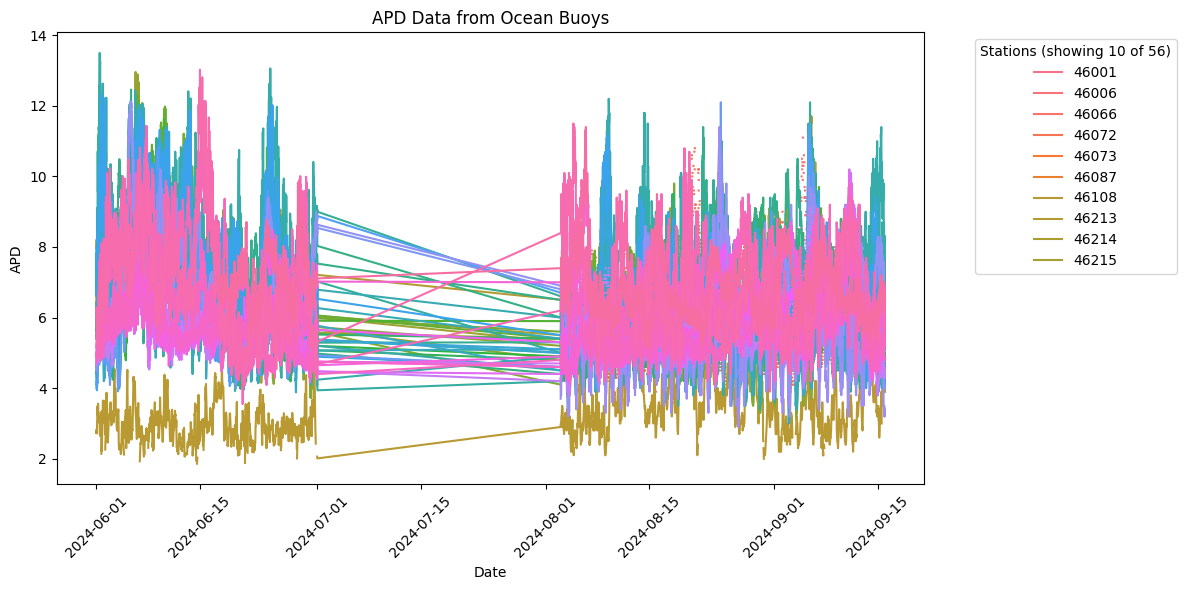

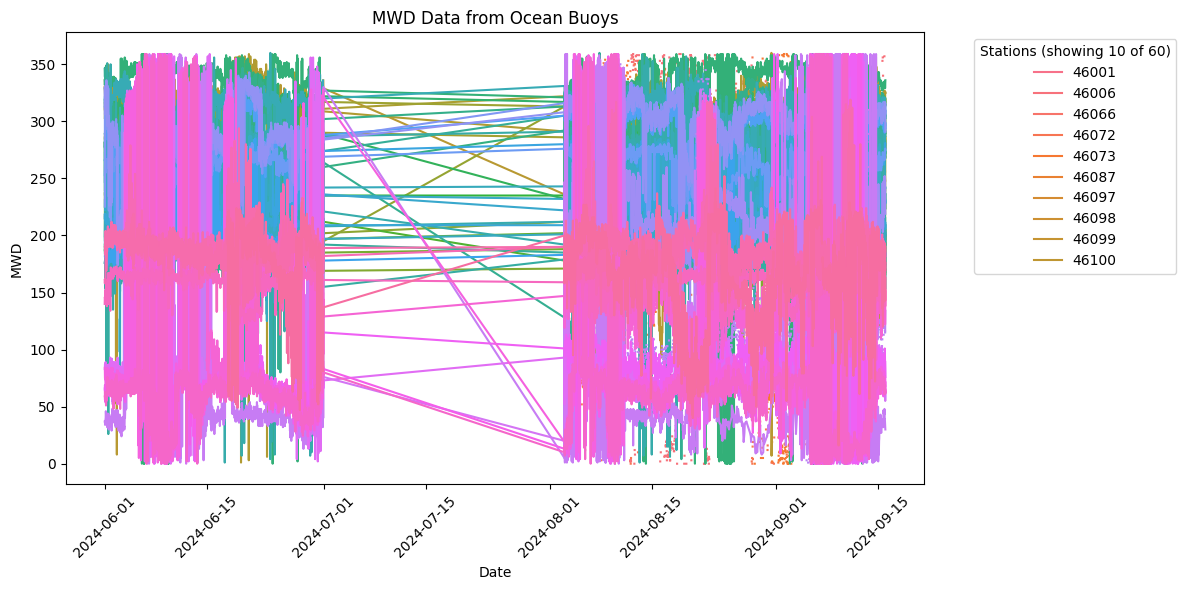

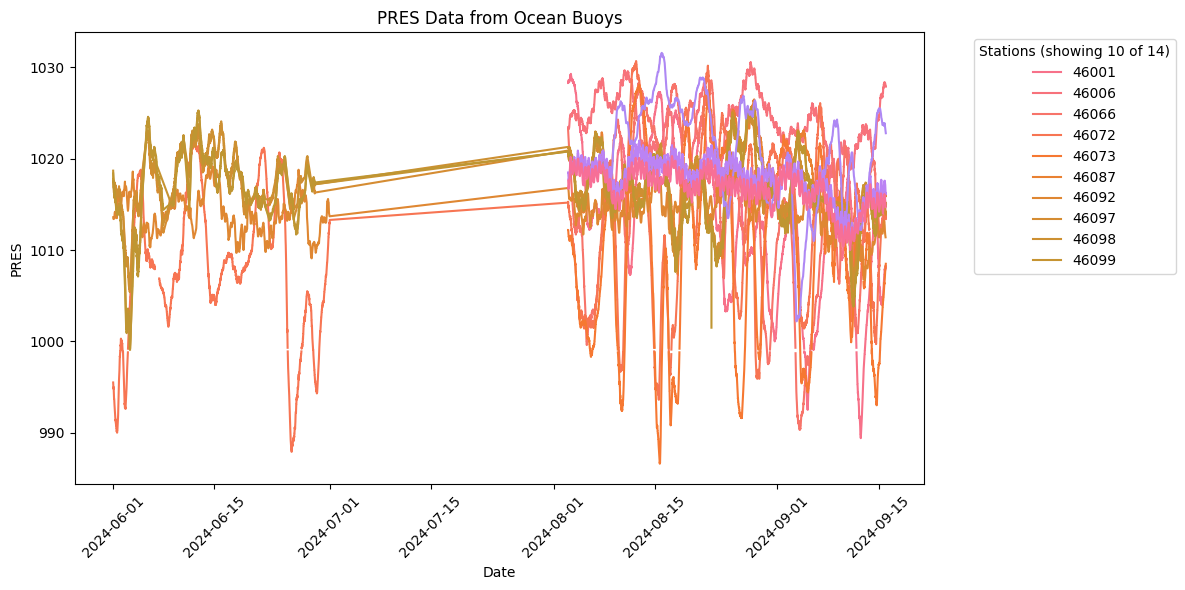

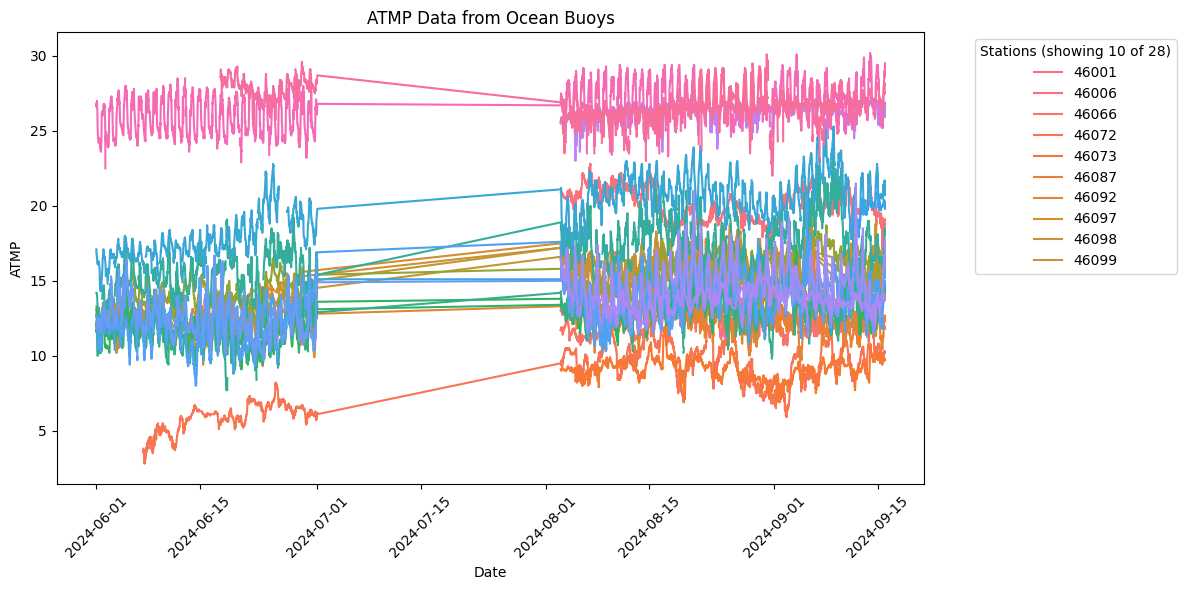

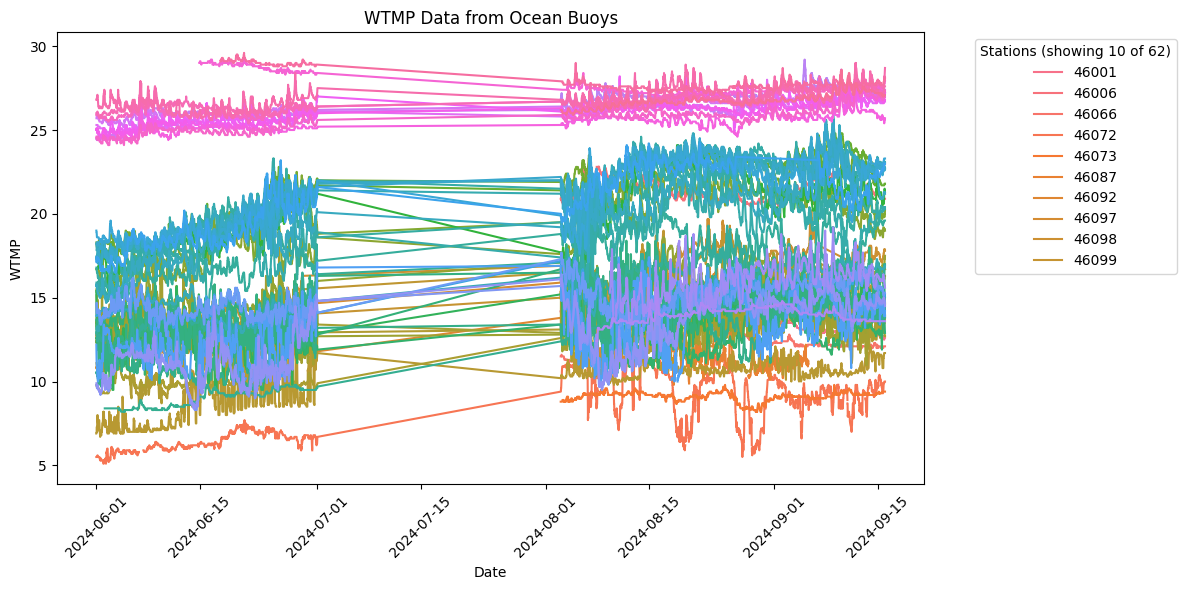

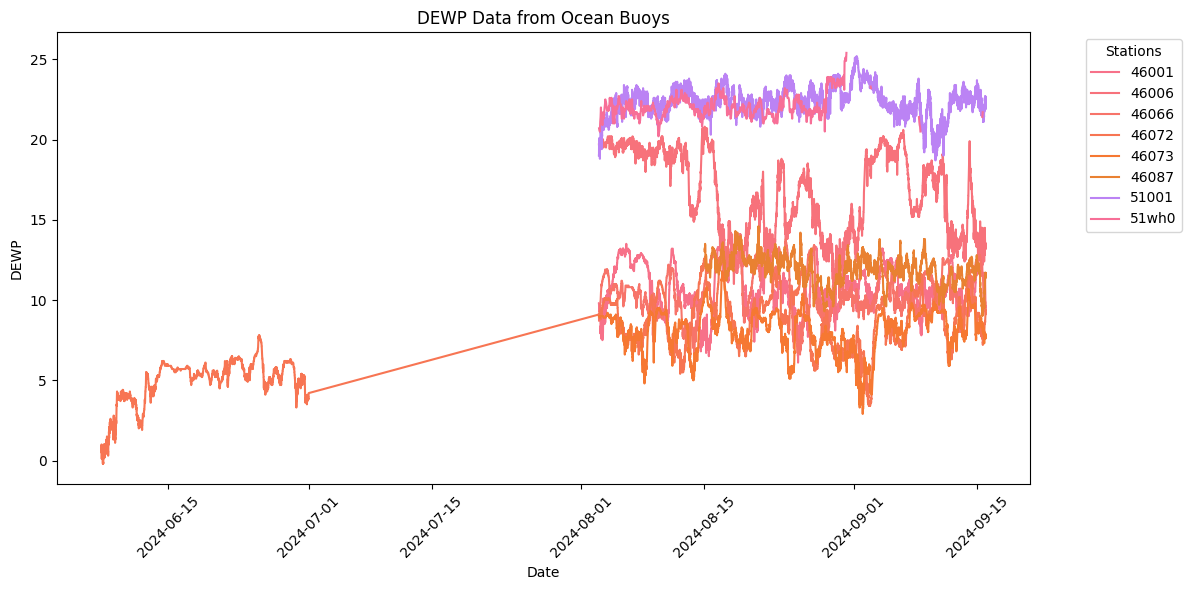

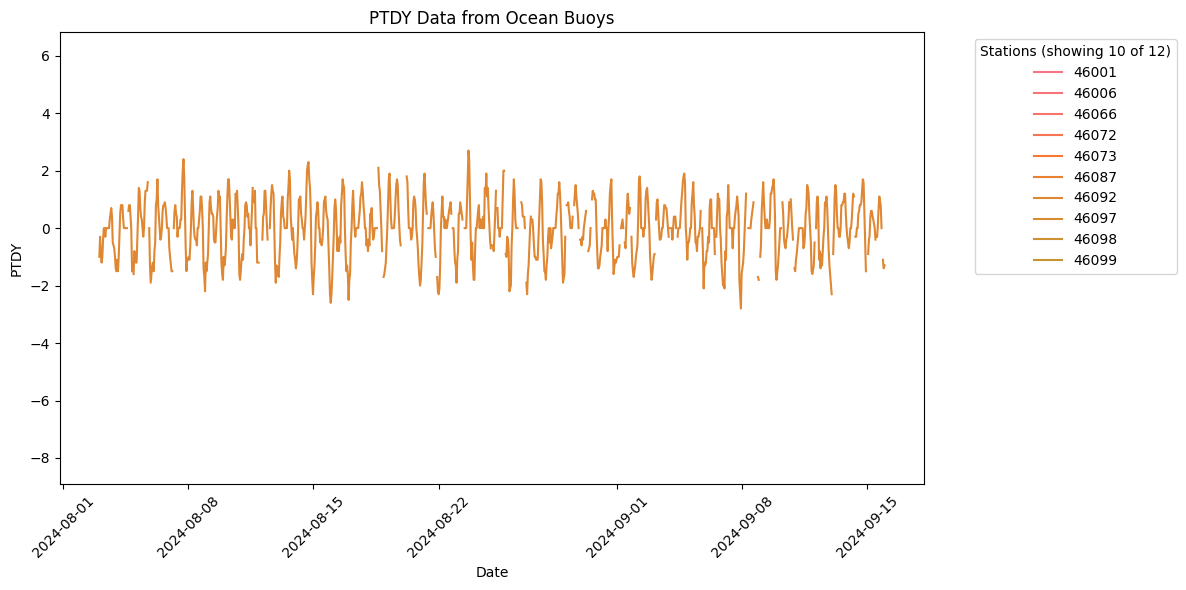

In [11]:
# Filter to only this Ocean
pacific_american_ocean_availability, pacific_american_ocean_station_data = filter_by_ocean(availability_df, station_data, buoy_df, "Pacific Ocean America")
plot_availability_heatmap(pacific_american_ocean_availability)
#  Plot the variables:
ocean_variable_plot(pacific_american_ocean_station_data, pacific_american_ocean_availability)